In [1]:
### import pandas as pd
from src.core.pivot_handler import PivotHandler
from src.core.segmentation_handler import CumulativeSegmentsSplitter
from src.models.models import get_data
from src.core.segmentation_handler import SegmentationHandler
from src.core.hypothesis_evaluation.test_evaluation import StatisticalTestHandler
from src.utils.tools import update_column_names,experiment_name,extract_experiment_name,find_query_name
from datetime import datetime
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt
from src.core.budget_evaluation import compute_result_budget
from utils.results import iterate_in_results
from src.core.hypothesis_evaluation.test_handler import run_tests_for
from src.core.hypothesis_evaluation.explore_results import get_plot_data,generate_stats,plot_result,generate_plot_data
from itertools import product
from scipy import stats
import datetime
import pandas as pd 
error_arg = "fdr_by"
corrected_err_column = f"p-value {error_arg}"


def extract_name(x):
    pivot = x["pivot"].replace("Retail_","").split()[0]
    segmentation = x["segmentation"].replace("Retail_","").replace("Amazon_","").split()[0]
    return find_query_name(pivot,segmentation)


from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt

def fix_legend(ax,title="Segmentations",position=3):
    ax.legend(loc=position,title=title,borderpad=0, labelspacing=0,markerscale=6,handletextpad=-0.5)

    # Legend edit 
    legend = ax.get_legend()    
    legend.get_title().set_position((0, 50)) # -10 is a guess
    legend.get_frame().set_linewidth(3)
    legend.get_frame().set_edgecolor("black")
    
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaller = MinMaxScaler()

independence_test_threshold = 0.05

error_arg = "fdr_by"

alpha = 0.05
approach = 1

In [2]:
data  = generate_stats(avoid_filter="",files_filter="",approach=1,alpha=0.05)
data2 = generate_stats(avoid_filter="",files_filter="",approach=1,alpha=0.01)
pd.concat([data,data2]).sort_values("#results")

#(h,e)   #e    #h  \
dataset         query# pivot           segmentation alpha                      
Amazon          #Q12   Promotion       Trend        0.05     1012   22    46   
Tafeng          #Q10   Demographics    Trend        0.01     3779   62    61   
Sales           #Q12   Promotion       Trend        0.01     5680   71    80   
                                                    0.01    17112   92   186   
RetailPromotion #Q12   RetailPromotion Trend        0.01    22748   96   245   
...                                                           ...  ...   ...   
Amazon          #Q3    Promotion       PWindow_1K   0.05    78076  131   596   
                                       PWindow_500  0.01   310851  261  1191   
                                                    0.01   310851  261  1191   
                                                    0.05   310851  261  1191   
                                                    0.05   310851  261  1191   

                                                           #results  \
dataset         query# pivot           segmentation alpha             
Amazon          #Q12   Promotion       Trend        0.05          0   
Tafeng          #Q10   Demographics    Trend        0.01          0   
Sales           #Q12   Promotion       Trend        0.01          0   
                                                    0.01          0   
RetailPromotion #Q12   RetailPromotion Trend        0.01          0   
...                                                             ...   
Amazon          #Q3    Promotion       PWindow_1K   0.05       9071   
                                       PWindow_500  0.01      61365   
                                                    0.01      61365   
                                                    0.05      61878   
                                                    0.05      61878   

                                                           #result(Bonferoni)  \
dataset         query# pivot           segmentation alpha                       
Amazon          #Q12   Promotion       Trend        0.05                    0   
Tafeng          #Q10   Demographics    Trend        0.01                    0   
Sales           #Q12   Promotion       Trend        0.01                    0   
                                                    0.01                    0   
RetailPromotion #Q12   RetailPromotion Trend        0.01                    0   
...                                                                       ...   
Amazon          #Q3    Promotion       PWindow_1K   0.05                 8955   
                                       PWindow_500  0.01                58456   
                                                    0.01                58456   
                                                    0.05                58929   
                                                    0.05                58929   

                                                           coverage  \
dataset         query# pivot           segmentation alpha             
Amazon          #Q12   Promotion       Trend        0.05          0   
Tafeng          #Q10   Demographics    Trend        0.01          0   
Sales           #Q12   Promotion       Trend        0.01          0   
                                                    0.01          0   
RetailPromotion #Q12   RetailPromotion Trend        0.01          0   
...                                                             ...   
Amazon          #Q3    Promotion       PWindow_1K   0.05      77463   
                                       PWindow_500  0.01     310013   
                                                    0.01     310013   
                                                    0.05     310013   
                                                    0.05     310013   

                                                                   min-p  \
dataset         query# pivot           s

In [2]:

for i in files:
    result = pd.read_csv(i,index_col=0)
    result = result[result["chi-squared test"]>=0.05]

    try:
        a = multipletests(result["p-value"],method=error_arg)
        result[corrected_err_column] =  a[1]
        result = result[a[0]]
    except:
        continue
    budget = 10000
    if result.shape[0]<2:
        continue
    plot_data = compute_result_budget(result,budget,corrected_err_column,plot=False,title=None)

    

def compute_result_budget(result, budget, corrected_err_column, plot=False, title=None, local=False):
    r = "e"
    budget = result[corrected_err_column].sum()
    result = result.set_index([corrected_err_column, r]).sort_index()
    
    ## Remove duplicates in index
    if not local:
        result = result[~result.index.get_level_values(1).duplicated(keep="first")]
    result["p-value"] = result.index.get_level_values(0)

    # Compute budget
    def compute_budget(result, budget):
        index = result.index
        for i in index:
            result.loc[i, "budget"] = budget - result.loc[:i, 'p-value'].sum()

    compute_budget(result, budget)

    # coverage
    result["coverage"] = 1
    if local:
        result.loc[result.index.get_level_values(1).duplicated(), "coverage"] = 1
    result["coverage"] = result["coverage"].cumsum() / result["#e"].unique()[0]

    # plot
    plot_data = result[result["budget"] >= 0].reset_index()[["coverage", "budget"]]
    plot_data.loc[len(plot_data)] = [0, budget]
    plot_data = plot_data.sort_values("coverage")
    if plot:
        ax = plot_data.plot.line(x="coverage", y="budget", title=title, figsize=(20, 8))
    return plot_data


NameError: name 'files' is not defined

experiments/results/pivot: Demographics ['gender'] , segmentation: Demographics ['location', 'gender'].csv


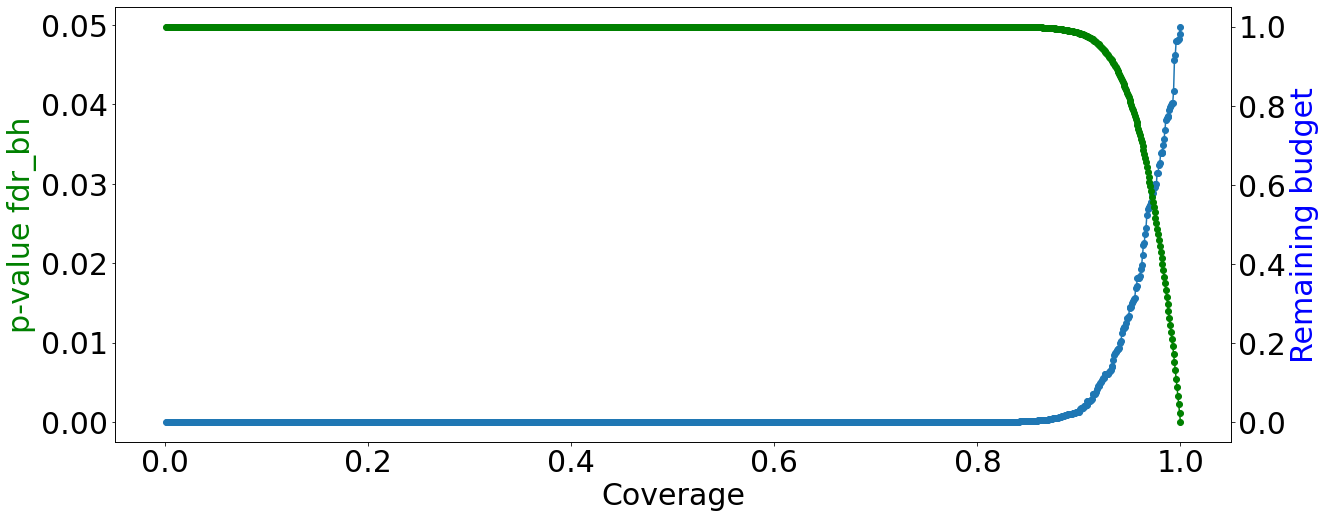

In [178]:


ax1 = plot_data[plot_column1].plot(figsize=(20,8),marker="o")
ax2 = ax1.twinx()
plot_data[plot_column2].plot(ax=ax2,figsize=(20,8),marker="o",color="green")


ax1.set_xlabel('Coverage')
ax1.set_ylabel(corrected_err_column, color='g')
ax2.set_ylabel('Remaining budget', color='b')

plt.show()



<AxesSubplot:xlabel='coverage'>

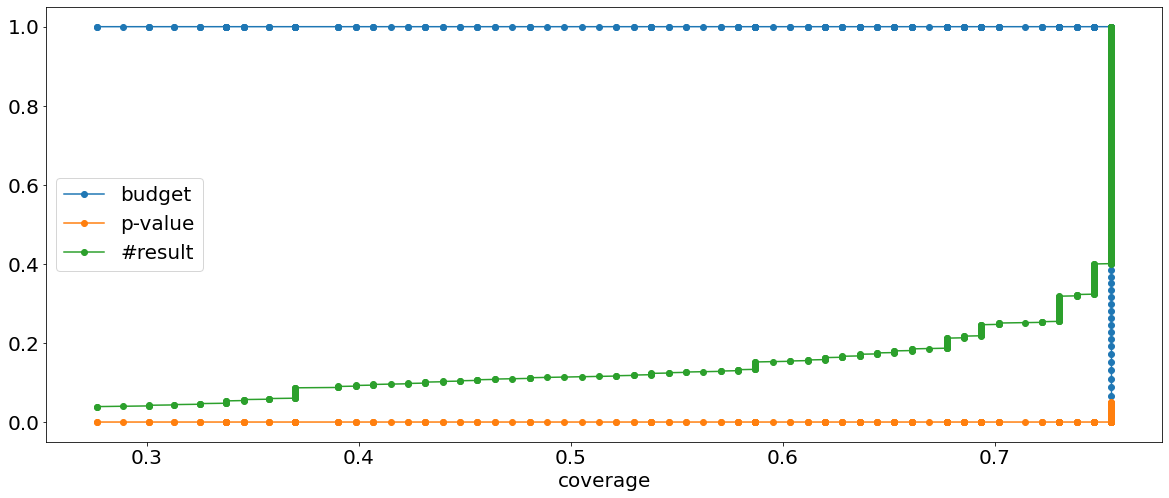

In [158]:
plot_column = "coverage"
plot_data = result[["budget","coverage",corrected_err_column,"#result"]].set_index(plot_column).sort_index()
plot_data = plot_data[plot_data[corrected_err_column]>0]
plot_data.plot(figsize=(20,8),marker="o")

In [71]:
result[corrected_err_column].cumsum().max()

2.21163414811329

In [55]:
result[corrected_err_column].cumsum().max()

2.21163414811329

In [24]:
# a,b = genxerate_stats()
# a

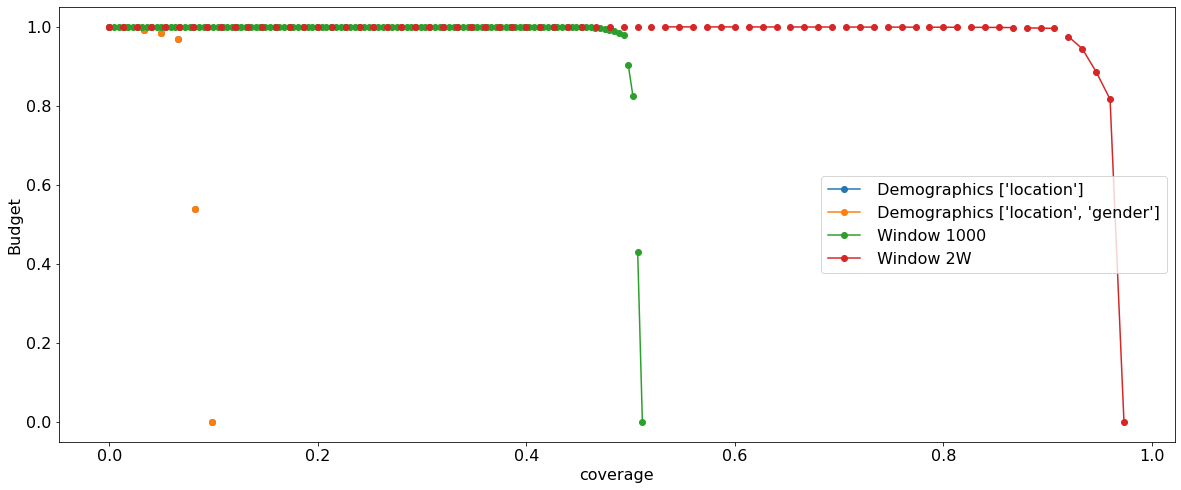

In [406]:
d = b.set_index("coverage").sort_index()
d = d[[i for i in d.columns if "pivot: D" in i]]
d.columns = [i.split("segmentation:")[1] for i in d.columns]
ax = ((d-d.min())/(d.max()-d.min())).plot.line(figsize=(20,8),marker="o")
plt.ylabel("Budget")
plt.show()
((d-d.min())/(d.max()-d.min())).to_csv("plot1.csv")

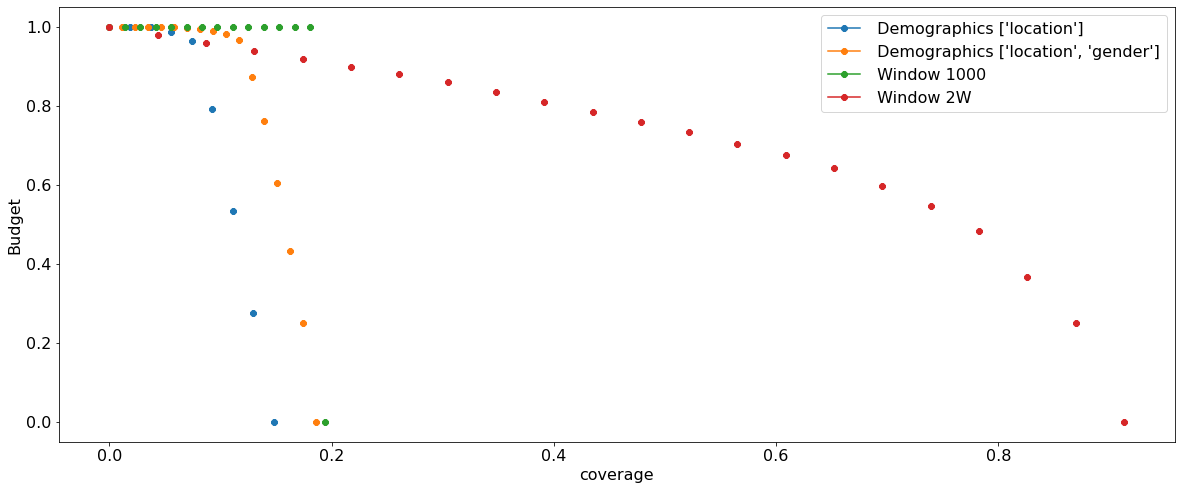

In [405]:
d = b.set_index("coverage").sort_index()
d = d[[i for i in d.columns if "pivot: P" in i]]
d.columns = [i.split("segmentation:")[1] for i in d.columns]
ax = ((d-d.min())/(d.max()-d.min())).plot.line(figsize=(20,8),marker="8")
plt.ylabel("Budget")
plt.show()
((d-d.min())/(d.max()-d.min())).to_csv("plot2.csv")

In [ ]:
d = b.set_index("coverage").sort_index()
d = d[[i for i in d.columns if "pivot: D" in i]]
d.columns = [i.split("segmentation:")[1] for i in d.columns]

ax = ((d-d.min())/(d.max()-d.min())).plot.line(figsize=(20,8),marker="o")
plt.ylabel("Budget")
plt.show()


In [2]:
b

NameError: name 'b' is not defined

In [331]:
result = pd.read_csv(files[2],index_col=0)

In [332]:
corrected_err_column

'p-value fdr_bh'

In [333]:
result
a = multipletests(result["p-value"],method=error_arg)
result[corrected_err_column] =  a[1]
budget = result["p-value fdr_bh"].sum()

result = result.set_index(["p-value fdr_bh", "e"]).sort_index()
index = result.index
for i in index:
    result.loc[i,"budget"] = budget - result.loc[:i,'p-value'].sum()
result

e_µ  e_std  \
p-value fdr_bh     e                                                      
0.0                2017-02-28 00:00:00-2019-12-30 00:00:00  57.3  27.04   
                   2017-02-28 00:00:00-2019-12-30 00:00:00 71.63  32.12   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  57.3  27.04   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  57.3  27.04   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  57.3  27.04   
...                                                          ...    ...   
0.99216747428684   2017-03-08 00:00:00-2019-01-29 00:00:00  0.05   0.37   
                   2017-07-20 00:00:00-2019-11-06 00:00:00  0.04   0.25   
                   2018-07-04 00:00:00-2019-09-03 00:00:00   0.0   0.07   
0.9937893700636616 2017-04-25 00:00:00-2019-12-23 00:00:00  0.13    0.6   
0.9970155185918146 2017-05-04 00:00:00-2018-07-18 00:00:00  0.01   0.08   

                                                            e_size  \
p-value fdr_bh     e                                                 
0.0                2017-02-28 00:00:00-2019-12-30 00:00:00   59364   
                   2017-02-28 00:00:00-2019-12-30 00:00:00   74204   
                   2017-02-28 00:00:00-2019-12-30 00:00:00   59364   
                   2017-02-28 00:00:00-2019-12-30 00:00:00   59364   
                   2017-02-28 00:00:00-2019-12-30 00:00:00   59364   
...                                                            ...   
0.99216747428684   2017-03-08 00:00:00-2019-01-29 00:00:00      34   
                   2017-07-20 00:00:00-2019-11-06 00:00:00      31   
                   2018-07-04 00:00:00-2019-09-03 00:00:00       2   
0.9937893700636616 2017-04-25 00:00:00-2019-12-23 00:00:00     125   
0.9970155185918146 2017-05-04 00:00:00-2018-07-18 00:00:00       3   

                                                                                                  h  \
p-value fdr_bh     e                                                                                  
0.0                2017-02-28 00:00:00-2019-12-30 00:00:00  2017-04-06 00:00:00-2019-11-26 00:00:00   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  2017-07-02 00:00:00-2019-07-26 00:00:00   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  2017-11-30 00:00:00-2019-08-29 00:00:00   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  2018-02-28 00:00:00-2019-07-16 00:00:00   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  2017-03-16 00:00:00-2019-11-04 00:00:00   
...                                                                                             ...   
0.99216747428684   2017-03-08 00:00:00-2019-01-29 00:00:00  2017-03-16 00:00:00-2019-11-04 00:00:00   
                   2017-07-20 00:00:00-2019-11-06 00:00:00  2018-01-30 00:00:00-2018-07-12 00:00:00   
                   2018-07-04 00:00:00-2019-09-03 00:00:00  2017-07-02 00:00:00-2019-07-26 00:00:00   
0.9937893700636616 2017-04-25 00:00:00-2019-12-23 00:00:00  2018-08-03 00:00:00-2019-07-12 00:00:00   
0.9970155185918146 2017-05-04 00:00:00-2018-07-18 00:00:00  2017-07-02 00:00:00-2019-07-04 00:00:00   

                                                            h_µ  h_std  \
p-value fdr_bh     e                                                     
0.0                2017-02-28 00:00:00-2019-12-30 00:00:00 0.02   0.17   
                   2017-02-28 00:00:00-2019-12-30 00:00:00 0.03   0.34   
                   2017-02-28 00:00:00-2019-12-30 00:00:00 0.01   0.13   
                   2017-02-28 00:00:00-2019-12-30 00:00:00 0.01    0.1   
                   2017-02-28 00:00:00-2019-12-30 00:00:00 0.02   0.16   
...                                                         ...    ...   
0.99216747428684   2017-03-08 00:00:00-2019-01-29 00:00:00 0.02   0.16   
                   2017-07-20 00:00:00-2019-11-06 00:00:00 0.01   0.11   
                   2018-07-04 00:00:00-2019-09-03 00:00:00 0.03   0.34   
0.9937893700636616 2

In [ ]:
r = "e"
result = result.set_index([corrected_err_column, r]).sort_index()

## Remove duplicates in index
if not local:
    result = result[~result.index.get_level_values(1).duplicated(keep="first")]
result["p-value"] = result.index.get_level_values(0)

# Compute budget
def compute_budget(result, budget):


compute_budget(result, budget)

# coverage
result["coverage"] = 1
if local:
    result.loc[result.index.get_level_values(1).duplicated(), "coverage"] = 1
result["coverage"] = result["coverage"].cumsum() / result["#e"].unique()[0]

# plot
plot_data = result[result["budget"] >= 0].reset_index()[["coverage", "budget"]]
plot_data.loc[len(plot_data)] = [0, budget]
plot_data = plot_data.sort_values("coverage")
if plot:
    ax = plot_data.plot.line(x="coverage", y="budget", title=title, figsize=(20, 8))
return plot_data



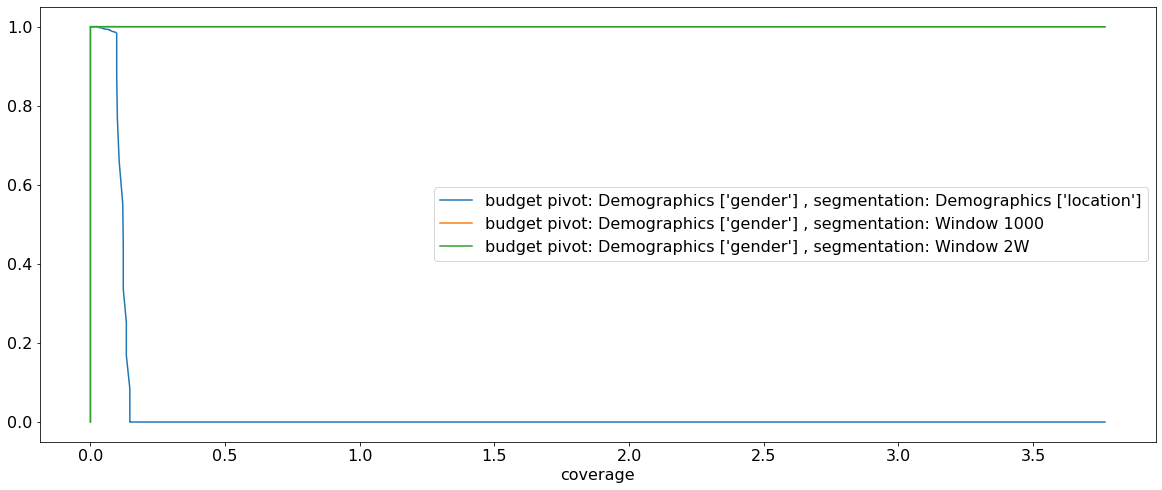

In [248]:
pd.set_option('display.float_format', str)
plt.rcParams["font.size"] = "16"


columns = ["coverage"]+[i for i in plots.columns[1:] if any(ii in i for ii in ["100","2W","location']"])]

d = plots[columns].set_index("coverage").sort_index().interpolate().fillna(1)

ax = ((d-d.min())/(d.max()-d.min())).plot(figsize=(20,8))
title="Budget consumption of behavioral pivot"


In [225]:
(d/d.max()).dropna().to_csv("data1.csv")

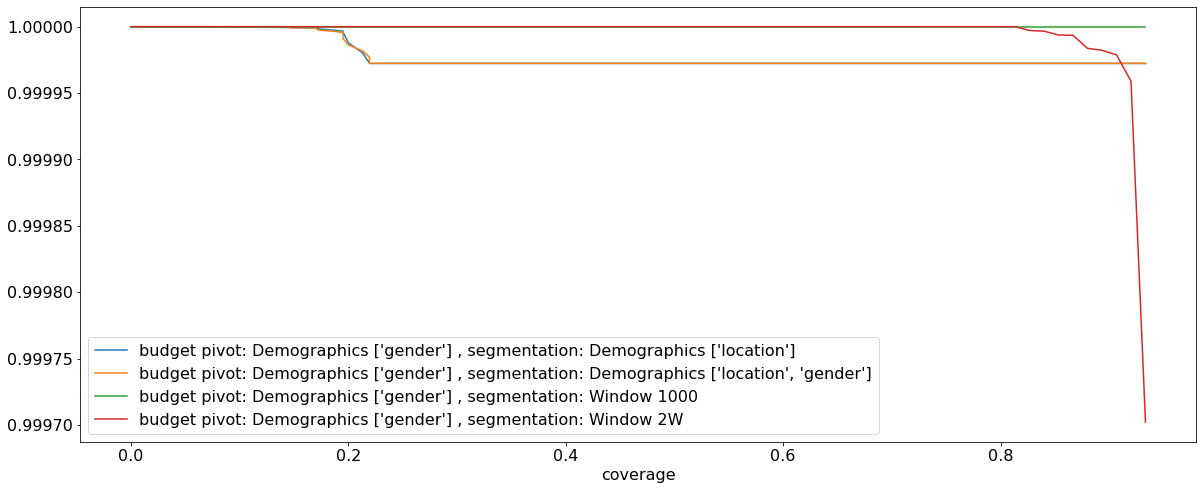

In [226]:
pd.set_option('display.float_format', str)
plt.rcParams["font.size"] = "16"
columns =["coverage"]+[ii for ii in plots.columns if "pivot: D" in ii  ]
d = plots[columns].set_index("coverage").sort_index().interpolate()
ax = (d/d.max()).dropna().plot(figsize=(20,8))
title="Budget consumption of behavioral pivot"


budget experiments/results/pivot: demographics ['gender'] , segmentation: temporal 100


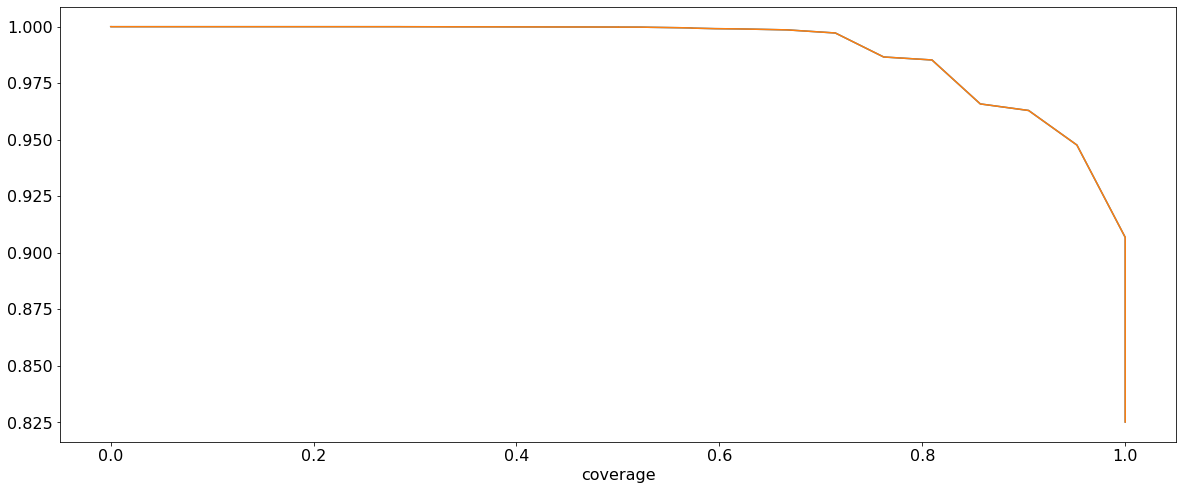

In [346]:
a = d/d.max()
ax = a[a.columns[0]].dropna().plot(figsize=(20,8))
for i in a.columns[0:1]:
    print(i)
    a[i].dropna().plot(ax=ax)

In [347]:
i

"budget experiments/results/pivot: demographics ['gender'] , segmentation: temporal 100"

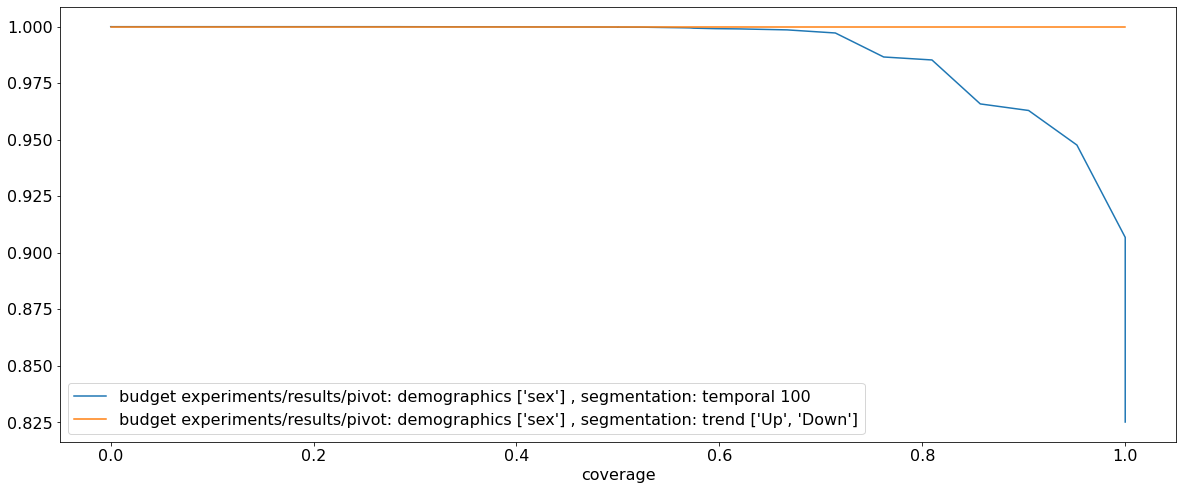

In [348]:
columns =["coverage"]+[ii for ii in plots.columns if "pivot: demog" in ii and "500" not in ii and '400' not in ii]
d = plots[sorted(columns)].set_index("coverage").sort_index().interpolate()
ax = (d/d.max()).plot(figsize=(20,8))
title="Budget consumption of demographic pivot"

In [121]:
columns =["coverage"]+[ii for ii in plots.columns if "pivot: promo" in ii and "500" not in ii and '400' not in ii and "gender" not in ii and "20" not in ii]
d = plots[columns].set_index("coverage").sort_index().interpolate()
ax = (d/d.max()).plot(figsize=(20,8))
title="Budget consumption of promotions pivot"


In [16]:
experiment_name(pivot_type,pivot_arg,segmentation_type,segmentation_arg)

"pivot: behavioral ['Up', 'Other'] , segmentation: temporal W"

In [24]:
r =[]
for i in range(0,len(res)):
    r.append((*res[i][1].split(" , "),res[i][0]["p-value (FDR)"].max(),res[i][0].shape[0],res[i][0]["p-value (FDR)"].max()*res[i][0].shape[0]))
pd.DataFrame(r,columns = ["pivot","segmentation","max(ap-val)","#result","#results * max(ap-val)"])

,pivot,segmentation,max(ap-val),#result,#results * max(ap-val)


In [222]:
result = pd.read_csv("experiments/results/pivot: Demographics ['gender'] , segmentation: Window 1000.csv",index_col=0)
a = multipletests(result["p-value"],method=error_arg)
result[corrected_err_column] =  a[1]
result = result[a[0]]
result

,e,e_size,h,h_size,t-value,p-value,e_normal,h_normal,chi-squared test,Dh_size,De_size,#h,#e,segmentation,pivot,test,p-value (FDR),p-value fdr_bh
2132,"1000, [2017-03-10,2019-10-25]",1000,"1000, [2017-03-05,2019-12-30]",1000,16.41551241875773,2.0892178520039963e-55,False,False,2.8542178086372024e-45,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,1.3851514358786495e-51,1.3851514358786495e-51
2141,"1000, [2017-03-10,2019-10-25]",1000,"1000, [2017-03-09,2019-12-16]",1000,16.23956048222697,7.713056431573314e-54,False,False,1.5102738815478304e-07,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,2.556878207066554e-50,2.5568782070665536e-50
2157,"1000, [2017-03-10,2019-10-25]",1000,"1000, [2017-03-10,2019-12-28]",1000,16.14591880245698,1.938957810327743e-53,False,False,3.5091608803109026e-07,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,4.285096760824312e-50,4.285096760824312e-50
3637,"1000, [2017-03-05,2019-12-30]",1000,"1000, [2017-03-10,2019-12-30]",1000,-16.113911261761718,4.1534049253674014e-53,False,False,0.3538628349545289,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,6.884268663796469e-50,6.884268663796467e-50
1147,"1000, [2017-03-04,2019-12-26]",1000,"1000, [2017-03-10,2019-12-30]",1000,-15.998121929320751,5.825365450111024e-53,False,False,4.522242031724327e-42,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,7.724434586847218e-50,7.724434586847218e-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,"1000, [2017-03-08,2019-12-30]",1000,"1000, [2017-03-07,2019-12-26]",1000,2.0953760220965822,0.0362614520101289,False,False,0.6260950673387191,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,0.0487555114230693,0.048755511423069275
2482,"1000, [2017-03-04,2019-12-27]",1000,"1000, [2017-03-08,2019-12-16]",1000,2.0892411775895376,0.0368098720461762,False,False,1.0,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,0.0494828571910277,0.049482857191027615
2782,"1000, [2017-03-08,2019-12-30]",1000,"1000, [2017-03-08,2019-12-16]",1000,2.089100818645951,0.0368227205344008,False,False,0.2422792342743703,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,0.0494900946975629,0.0494900946975628
1110,"1000, [2017-03-04,2019-12-26]",1000,"1000, [2017-03-09,2019-12-30]",1000,-2.0874118876146928,0.03697463416833,False,False,9.534701775957064e-23,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,0.0496841962983438,0.04968419629834372


In [213]:
i

"experiments/results/pivot: Demographics ['gender'] , segmentation: Window 2W.csv"

In [110]:
res = [i for i in res_copy.copy() if "pivot: de" in i[1]]
plot_results(res)

In [78]:
import numpy as np
import matplotlib.pyplot as plt

res = [i for i in res_copy.copy() if "Up"in i[1]]
a,b = res[0]

plot_data = compute_result_budget(a,a["p-value"].max()*a.shape[0],plot=False,title=b)
plot_data.columns = ["coverage",b]
ax = plot_data.set_index("coverage").plot(figsize=(20,8))

for a,b in res:
    plot_data = compute_result_budget(a,a["p-value"].shape[0]*a["p-value"].max(),plot=False,title=b)
    plot_data.columns = ["coverage",b]
    plot_data.set_index("coverage").plot(ax=ax)
plt.show()


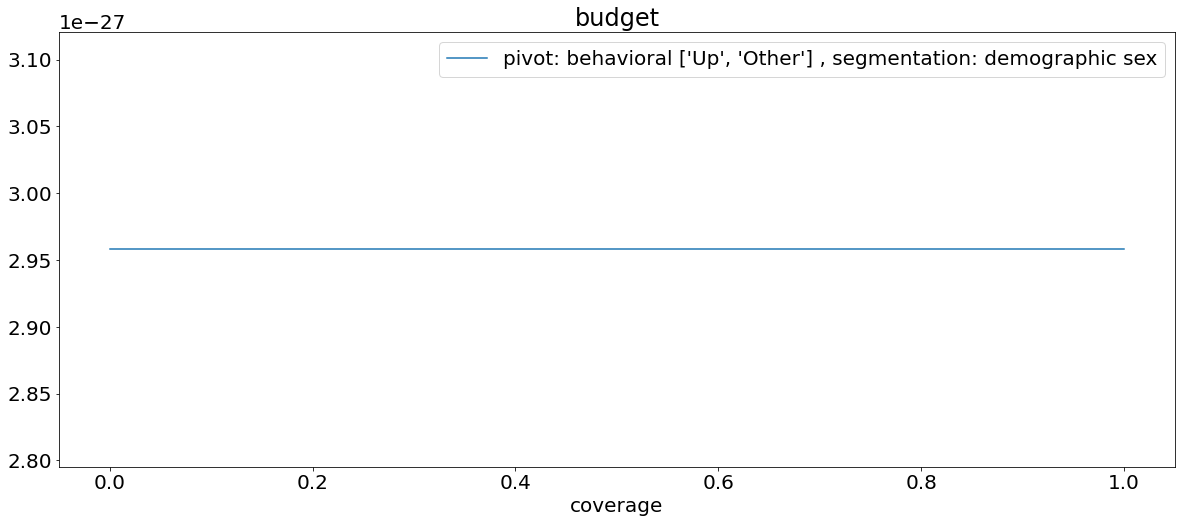

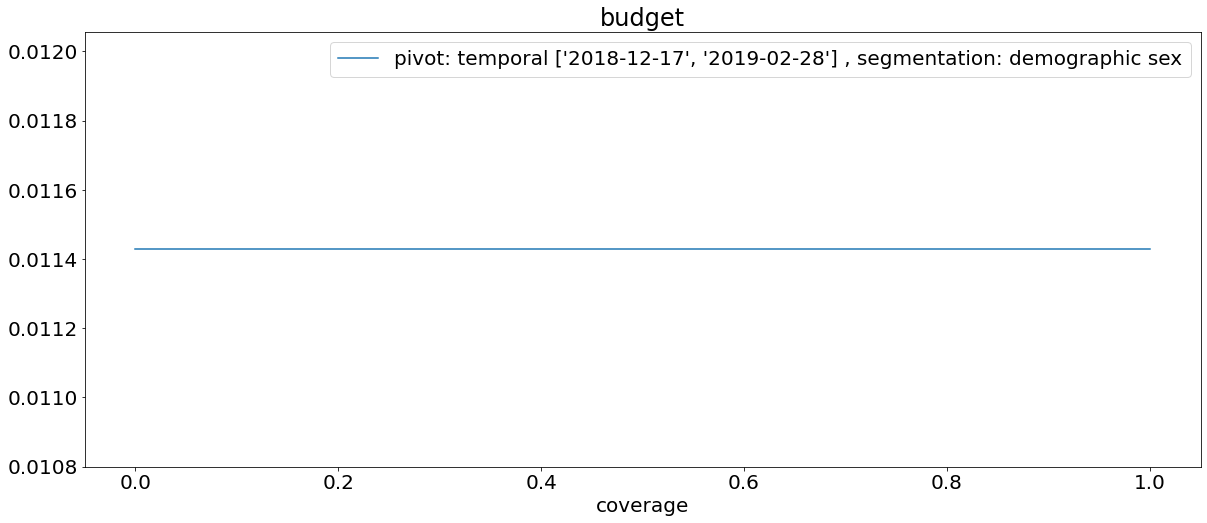

In [16]:
plt.rcParams["font.size"] = "20"
for a,b in res:
    if "temporal 400" in b:
        continue
    plot_data = compute_result_budget(a,a["p-value"].sum(),plot=False,title=b)
    plot_data.columns = ["coverage",b]
    plot_data.set_index("coverage").plot(title="budget",figsize=(20,8))
    plt.show()

In [220]:
def compute_result_budget(result,budget,plot=False,title=None):
    r = [i for i in result.columns if "r_" in i ][0]
    result = result.set_index(["p-value (FDR)",r]).sort_index()


    ## Remove duplicates in index 
    result = result[~result.index.get_level_values(1).duplicated(keep="first")]
    result["p-value"] = result.index.get_level_values(0)

    # Compute budget 
    def compute_budget(result,budget):
        index = result.index
        for i in index:
            result.loc[i,"budget"] = budget - result.loc[:i].shape[0] * result.loc[:i,'p-value'].max()
    compute_budget(result,budget)
    # coverage 
    result["coverage"] = 1
    result["coverage"] = result["coverage"].cumsum() /result["#r"].unique()[0] 


    # plot 
    plot_data = result[result["budget"]>=0].reset_index()[["coverage","budget"]]
    plot_data.loc[len(plot_data)]=[0,budget]
    plot_data = plot_data.sort_values("coverage")
    if plot:
        ax = plot_data.plot.line(x="coverage",y="budget",title=title,figsize=(20,8))
    return plot_data


In [13]:
pd.read_csv("results_example.csv",index_col=0)

,t_>2019-02-28,t_size,r_<2018-12-17,r_size,t-value,p-value,R_size,T_size,#r,#t,segmentation,pivot,test,p-value (FDR)
821,"200, [2019-02-28,2019-11-08]",200,"200, [2017-04-05,2018-12-13]",200,7.313447,5.908487e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
838,"200, [2019-02-28,2019-11-08]",200,"200, [2017-05-11,2018-12-14]",200,7.282992,7.554008e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
816,"200, [2019-02-28,2019-11-08]",200,"200, [2017-05-05,2018-12-11]",200,7.275560,7.932785e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
827,"200, [2019-02-28,2019-11-08]",200,"200, [2017-05-11,2018-12-17]",200,7.262562,8.684162e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
845,"200, [2019-02-28,2019-11-08]",200,"195, [2017-06-02,2018-12-17]",195,7.265274,8.706355e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,"200, [2019-03-04,2019-12-30]",200,"200, [2017-10-05,2018-12-14]",200,2.776233,5.638996e-03,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,5.875112e-03
105,"200, [2019-02-28,2019-12-30]",200,"200, [2017-10-05,2018-12-14]",200,2.772189,5.708022e-03,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,5.942149e-03
1092,"200, [2019-02-28,2019-12-30]",200,"200, [2017-10-05,2018-12-14]",200,2.714986,6.782334e-03,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,7.054739e-03
904,"200, [2019-02-28,2019-12-26]",200,"200, [2017-10-05,2018-12-14]",200,2.700758,7.077229e-03,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,7.355450e-03


In [10]:
!ls *.csv

 all_experiments.csv
''\''_'\''.join(str(i) for i in [pivot_type,pivot_arg,segmentation_type,segmentation_arg,test_type,test_arg,error_correction_test,threshold,plot]).csv'
 partitionning_cumulative_0.1.csv
 partitionning_cumulative_0.2.csv
 partitionning_cumulative_0.35.csv
 partitionning_cumulative_0.5.csv
 partitionning_cumulative_0.csv
 results_example.csv
 starting_data.csv
 temporal_segmentaiton_results.csv
 test.csv


In [72]:

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

X = np.linspace(0,1,1000)
Y = np.cos(X*20)

ax1.plot(X,Y)
ax1.set_xlabel(r"Original x-axis: $X$")

new_tick_locations = np.array([.2, .5, .9])

def tick_function(X):
    V = 1/(1+X)
    return ["%.3f" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
plt.show()

In [ ]:
df_stats = pd.DataFrame(res)
df_stats.columns = ["pivot",'pivot_arg','segmentation','segmentation_arg','agg','','error control','alpha','#results',"sum ap-value",'r_coverage','t_coverage'] 
df_stats

In [20]:
'_'.join(str(i) for i in [pivot_type,pivot_arg,segmentation_type,segmentation_arg,test_type,test_arg,error_correction_test,threshold,plot])

"demographics_['gender']_temporal_Y_mean__FDR_0.05_False"

In [26]:
print(df_stats.to_latex(index=False))

\begin{tabular}{lllllllrrrrr}
\toprule
       pivot &         pivot\_arg & segmentation & segmentation\_arg &  agg & {} & error control &  alpha &  \#results &  sum ap-value &  r\_coverage &  t\_coverage \\
\midrule
demographics & ['gender'] (r=F,t=M) &     temporal &                W & mean & {} &           FDR &   0.05 &     21904 &  1.942374e+02 &    0.993289 &    0.993289 \\
demographics & ['gender'] (r=F,t=M) &     temporal &               2W & mean & {} &           FDR &   0.05 &      5625 &  5.109631e+01 &    1.000000 &    1.000000 \\
demographics & ['gender'] (r=F,t=M) &     temporal &               3W & mean & {} &           FDR &   0.05 &      2500 &  3.000554e+01 &    0.980392 &    0.980392 \\
demographics & ['gender'] (r=F,t=M) &     temporal &                M & mean & {} &           FDR &   0.05 &      1156 &  2.267783e-06 &    1.000000 &    0.971429 \\
demographics & ['gender'] (r=F,t=M) &     temporal &               3M & mean & {} &           FDR &   0.05 &       144 &

In [30]:
df_stats[["r_coverage","t_coverage"]].apply(lambda x : f'{x}')

0    r_coverage    0.993289\nt_coverage    0.993289...
1    r_coverage    1.0\nt_coverage    1.0\nName: 1,...
2    r_coverage    0.980392\nt_coverage    0.980392...
3    r_coverage    1.000000\nt_coverage    0.971429...
4    r_coverage    1.000000\nt_coverage    0.923077...
5    r_coverage    1.000000\nt_coverage    0.857143...
6    r_coverage    1.0\nt_coverage    0.8\nName: 6,...
7    r_coverage    1.0\nt_coverage    1.0\nName: 7,...
dtype: object

In [3]:
temporal_pivot_argument = [df.index[300],df.index[500]]
reference_set,test_set = pivot_handler.pivot("temporal",df,temporal_pivot_argument)
print(reference_set.shape,test_set.shape)

(1371891, 9) (482113, 9)


In [9]:
isinstance(test_set, pd.DataFrame)

True

In [4]:
temporal_pivot_argument 

[Timestamp('2017-12-09 00:00:00'), Timestamp('2017-11-16 00:00:00')]

In [14]:
splitter = CumulativeSegmentsSplitter()

TypeError: 'CumulativeSegmentsSplitter' object is not callable

In [10]:
import numpy as np

In [12]:
np.diff([1,2,3],[1,2])

TypeError: '<' not supported between instances of 'list' and 'int'

In [50]:
def a(b=[]):
    b.append(123)
    print(b)

a()
a()
a()

[123]
[123, 123]
[123, 123, 123]


In [52]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/abdelouahab/.virtualenvs/SSQ/bin/python
3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


In [49]:
a()

[123, 123, 123]
